
# AVPrivacy Pipeline Demo — Face Detection → Mask Construction → Anonymization

This notebook walks through the full **AVPrivacyMasker** pipeline step by step, using sample frames on disk.
It demonstrates both masking paths:

- **Depth‑guided masks** (use depth to refine each face region)
- **Box‑only masks** (no depth required; draws padded ovals over detected face boxes)

For each step, we time the operation and visualize the intermediate outputs. Batch results are recorded in a table and saved to disk.

**Paths assumed (edit in the next cell if your layout differs):**
- Root repo: `/home/summer2025/AVPrivacy/AVPrivacy-Simulation`
- Masking class: `av_privacy_masker.py`
- Demo inputs:
  - RGB: `demo_inputs/rgb/frame*.jpg|png`
  - Depth: `demo_inputs/depth/depth_mm*.png|jpg` (uint16 millimeters or 8‑bit preview OK)
- Demo outputs: `demo_outputs/anon/{depth_path, boxonly_path}`


In [1]:

from pathlib import Path
import sys, os

# --- Edit these if needed ---
REPO_ROOT = Path("/home/summer2025/AVPrivacy/AVPrivacy-Simulation").resolve()
MASKER_PATH = REPO_ROOT / "av_privacy_masker.py"
RGB_DIR = REPO_ROOT / "demo_inputs" / "rgb"
DEPTH_DIR = REPO_ROOT / "demo_inputs" / "depth"
OUT_BASE = REPO_ROOT / "demo_outputs" / "anon"
OUT_DEPTH_PATH = OUT_BASE / "depth_path"
OUT_BOXONLY_PATH = OUT_BASE / "boxonly_path"

# Create output dirs
OUT_DEPTH_PATH.mkdir(parents=True, exist_ok=True)
OUT_BOXONLY_PATH.mkdir(parents=True, exist_ok=True)

# Add repo to import path and import the masker
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

from av_privacy_masker import AVPrivacyMasker

print("Repo root:", REPO_ROOT)
print("Masker module:", MASKER_PATH.exists())
print("RGB samples:", len(list(RGB_DIR.glob('frame*.*'))))
print("Depth samples:", len(list(DEPTH_DIR.glob('depth_mm*.*'))))


/home/summer2025/miniconda3/envs/python37-911/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Repo root: /home/summer2025/AVPrivacy/AVPrivacy-Simulation
Masker module: True
RGB samples: 200
Depth samples: 200


In [2]:

import cv2
import numpy as np
import time
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

def load_bgr(path):
    """Load image in BGR; return np.uint8 [H,W,3]."""
    img = cv2.imread(str(path), cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {path}")
    return img

def load_depth_any(path):
    """
    Robust depth load:
    - uint16 millimeters or meters (kept as float32)
    - 8-bit preview (normalize to [0,255] then to float32)
    Returns float32 depth array shape [H,W].
    """
    d = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
    if d is None:
        raise FileNotFoundError(f"Could not read depth: {path}")
    if d.dtype == np.uint16:
        d = d.astype(np.float32)  # keep in original scale (mm); algorithm uses relative values
    elif d.dtype == np.uint8:
        d = d.astype(np.float32)  # [0..255] still fine for relative thresholding
    else:
        d = d.astype(np.float32)
    return d

def show_side_by_side(images, titles=None, figsize=(12,6)):
    """Display images (BGR or gray) side by side with optional titles."""
    n = len(images)
    plt.figure(figsize=figsize)
    for i, im in enumerate(images, 1):
        plt.subplot(1, n, i)
        if im.ndim == 2:
            plt.imshow(im, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
        if titles:
            plt.title(titles[i-1])
        plt.axis('off')
    plt.show()


In [3]:
import torch, subprocess
print("torch:", torch.__version__, "cuda:", torch.version.cuda)
print("is_available:", torch.cuda.is_available(), "count:", torch.cuda.device_count())
print("name0:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "n/a")
print(subprocess.check_output(["nvidia-smi"], text=True)[:600])

torch: 1.13.1+cu117 cuda: 11.7
is_available: True count: 2
name0: NVIDIA GeForce RTX 4090
Thu Aug 28 15:51:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.133.20             Driver Version: 570.133.20     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|===============


In [4]:

# Tunable parameters
CONF_THRESH = 0.5
ANON_BLOCK = 16     # pixelation block size
ANON_NOISE = 20     # 0..255 range
DILATE_KERNEL = 13  # boundary smoothing

masker = AVPrivacyMasker(
    device="cuda" if hasattr(__import__("torch"), "cuda") and __import__("torch").cuda.is_available() else "cpu",
    conf_thresh=CONF_THRESH,
    anon_block=ANON_BLOCK,
    anon_noise=ANON_NOISE,
    dilate_kernel=DILATE_KERNEL,
    det_size=(2048, 2048),
    verbose=False,
    enable_depth_anon=False,  # set True if you want to anonymize depth as well
)

print("Masker device:", masker.device)


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /home/summer2025/.insightface/models/buffalo_s/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /home/summer2025/.insightface/models/buffalo_s/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/summer2025/.insightface/models/buffalo_s/det_500m.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /home/summer2025/.insightface/models/buffalo_s/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /home/summer2025/.insightface/models/buffalo_s/w600k_mbf.onnx recognition
set det-size: (2048, 2048)
Masker device: cuda


In [5]:

# Pick a few matching RGB/depth pairs by numeric suffix
rgb_files = sorted([p for p in RGB_DIR.glob("frame*.*")])
depth_files = sorted([p for p in DEPTH_DIR.glob("depth_mm*.*")])

print("Found", len(rgb_files), "RGB &", len(depth_files), "Depth files")

# Keep a small subset for demos (edit if desired)
SAMPLE_N = 6
rgb_files = rgb_files[40:40+SAMPLE_N]
depth_files = depth_files[40:40+SAMPLE_N]
list(zip(rgb_files, depth_files))[:3]


Found 200 RGB & 200 Depth files


[(PosixPath('/home/summer2025/AVPrivacy/AVPrivacy-Simulation/demo_inputs/rgb/frame_1756419676535.jpg'),
  PosixPath('/home/summer2025/AVPrivacy/AVPrivacy-Simulation/demo_inputs/depth/depth_mm_1756419676535.png')),
 (PosixPath('/home/summer2025/AVPrivacy/AVPrivacy-Simulation/demo_inputs/rgb/frame_1756419676587.jpg'),
  PosixPath('/home/summer2025/AVPrivacy/AVPrivacy-Simulation/demo_inputs/depth/depth_mm_1756419676587.png')),
 (PosixPath('/home/summer2025/AVPrivacy/AVPrivacy-Simulation/demo_inputs/rgb/frame_1756419676641.jpg'),
  PosixPath('/home/summer2025/AVPrivacy/AVPrivacy-Simulation/demo_inputs/depth/depth_mm_1756419676641.png'))]


## 1) Single-frame Walkthrough — Depth‑Guided


Sample shapes: (480, 640, 3) (480, 640)
Timings (ms)  detect=111.6  mask=0.9  anonymize=8.2


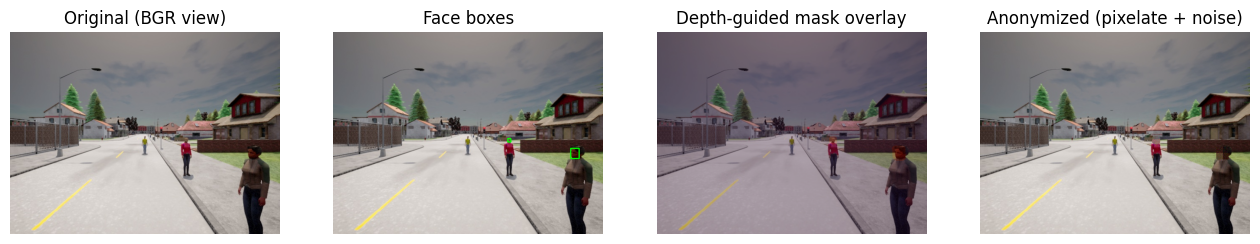

In [6]:

if not rgb_files or not depth_files:
    raise RuntimeError("No demo files found. Please populate demo_inputs/rgb and demo_inputs/depth.")

rgb_path = rgb_files[0]
depth_path = depth_files[0]

bgr = load_bgr(rgb_path)
depth = load_depth_any(depth_path)

print("Sample shapes:", bgr.shape, depth.shape)

# 1) Detect
t0 = time.perf_counter()
boxes = masker.detect_faces(bgr)
t_detect = time.perf_counter() - t0

# Visualize boxes
boxed = bgr.copy()
for (x1,y1,x2,y2) in boxes:
    cv2.rectangle(boxed, (x1,y1), (x2,y2), (0,255,0), 2)

# 2) Mask (depth-guided)
t1 = time.perf_counter()
mask_np = masker.build_mask_numpy(depth, boxes, masker.kernel, masker._calc_depth_profile)
t_mask = time.perf_counter() - t1

mask_vis = (mask_np*255).astype(np.uint8)
mask_vis_color = cv2.applyColorMap(mask_vis, cv2.COLORMAP_TURBO)
mask_overlay = cv2.addWeighted(bgr, 0.7, mask_vis_color, 0.3, 0)

# 3) Anonymize
t2 = time.perf_counter()
anon = masker.fast_pixelate(bgr, mask_np, block=ANON_BLOCK, noise=ANON_NOISE)
t_anon = time.perf_counter() - t2

print(f"Timings (ms)  detect={t_detect*1000:.1f}  mask={t_mask*1000:.1f}  anonymize={t_anon*1000:.1f}")

show_side_by_side(
    [bgr, boxed, mask_overlay, anon],
    titles=["Original (BGR view)", "Face boxes", "Depth‑guided mask overlay", "Anonymized (pixelate + noise)"],
    figsize=(16,6)
)



## 2) Single-frame Walkthrough — Box‑Only (No Depth)


Timings (ms)  detect=107.0  mask=0.6  anonymize=8.4


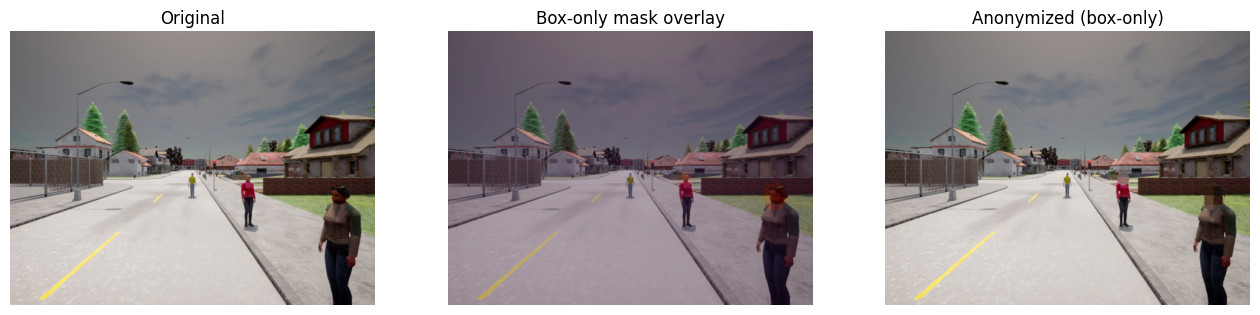

In [7]:

PAD_RATIO = 0.25
OVAL = True

# 1) Detect (time again for fairness)
t0 = time.perf_counter()
boxes2 = masker.detect_faces(bgr)
t_detect2 = time.perf_counter() - t0

# 2) Mask (box-only)
t1 = time.perf_counter()
mask_box = masker.build_mask_from_boxes(boxes2, bgr.shape, pad_ratio=PAD_RATIO, oval=OVAL)
t_mask2 = time.perf_counter() - t1

mask_box_vis = (mask_box*255).astype(np.uint8)
mask_box_color = cv2.applyColorMap(mask_box_vis, cv2.COLORMAP_TURBO)
overlay_box = cv2.addWeighted(bgr, 0.7, mask_box_color, 0.3, 0)

# 3) Anonymize
t2 = time.perf_counter()
anon_box = masker.fast_pixelate(bgr, mask_box, block=ANON_BLOCK, noise=ANON_NOISE)
t_anon2 = time.perf_counter() - t2

print(f"Timings (ms)  detect={t_detect2*1000:.1f}  mask={t_mask2*1000:.1f}  anonymize={t_anon2*1000:.1f}")

show_side_by_side(
    [bgr, overlay_box, anon_box],
    titles=["Original", "Box‑only mask overlay", "Anonymized (box‑only)"],
    figsize=(16,5)
)



## 3) Batch Demo — Depth Path


In [8]:

import pandas as pd
records = []

for rgb_p, dep_p in zip(rgb_files, depth_files):
    bgr = load_bgr(rgb_p)
    depth = load_depth_any(dep_p)
    # detect
    t0 = time.perf_counter()
    boxes = masker.detect_faces(bgr)
    t_detect = time.perf_counter() - t0
    # mask (depth)
    t1 = time.perf_counter()
    mask_np = masker.build_mask_numpy(depth, boxes, masker.kernel, masker._calc_depth_profile)
    t_mask = time.perf_counter() - t1
    # anonymize
    t2 = time.perf_counter()
    anon = masker.fast_pixelate(bgr, mask_np, block=ANON_BLOCK, noise=ANON_NOISE)
    t_anon = time.perf_counter() - t2

    out_name = OUT_DEPTH_PATH / f"anon_{rgb_p.stem}.jpg"
    # Save as RGB for convenience
    anon_rgb = cv2.cvtColor(anon, cv2.COLOR_BGR2RGB)
    cv2.imwrite(str(out_name), anon_rgb)

    records.append({
        "file": rgb_p.name,
        "n_faces": len(boxes),
        "detect_ms": t_detect*1000.0,
        "mask_ms": t_mask*1000.0,
        "anon_ms": t_anon*1000.0,
        "total_ms": (t_detect+t_mask+t_anon)*1000.0,
        "path": str(out_name)
    })

df_depth = pd.DataFrame(records)
df_depth


,file,n_faces,detect_ms,mask_ms,anon_ms,total_ms,path
0,frame_1756419676535.jpg,2,105.800212,0.728340,8.280224,114.808776,/home/summer2025/AVPrivacy/AVPrivacy-Simulatio...
1,frame_1756419676587.jpg,2,103.289118,0.735934,8.291184,112.316236,/home/summer2025/AVPrivacy/AVPrivacy-Simulatio...
2,frame_1756419676641.jpg,2,102.971296,0.715955,8.227754,111.915005,/home/summer2025/AVPrivacy/AVPrivacy-Simulatio...
3,frame_1756419676696.jpg,2,102.539057,0.723099,8.208878,111.471035,/home/summer2025/AVPrivacy/AVPrivacy-Simulatio...
4,frame_1756419676751.jpg,2,103.245164,0.726706,8.345917,112.317787,/home/summer2025/AVPrivacy/AVPrivacy-Simulatio...
5,frame_1756419676804.jpg,2,103.239282,0.727016,8.377778,112.344076,/home/summer2025/AVPrivacy/AVPrivacy-Simulatio...


In [9]:

print("\nAverages (ms):")
df_depth[["detect_ms","mask_ms","anon_ms","total_ms"]].mean().to_frame("mean_ms")



Averages (ms):


,mean_ms
detect_ms,103.514022
mask_ms,0.726175
anon_ms,8.288623
total_ms,112.528819



## 4) Batch Demo — Box‑Only Path


In [10]:

records2 = []

for rgb_p in rgb_files:
    bgr = load_bgr(rgb_p)
    # detect
    t0 = time.perf_counter()
    boxes = masker.detect_faces(bgr)
    t_detect = time.perf_counter() - t0
    # mask (box-only)
    t1 = time.perf_counter()
    mask_np = masker.build_mask_from_boxes(boxes, bgr.shape, pad_ratio=PAD_RATIO, oval=OVAL)
    t_mask = time.perf_counter() - t1
    # anonymize
    t2 = time.perf_counter()
    anon = masker.fast_pixelate(bgr, mask_np, block=ANON_BLOCK, noise=ANON_NOISE)
    t_anon = time.perf_counter() - t2

    out_name = OUT_BOXONLY_PATH / f"anon_{rgb_p.stem}.jpg"
    anon_rgb = cv2.cvtColor(anon, cv2.COLOR_BGR2RGB)
    cv2.imwrite(str(out_name), anon_rgb)

    records2.append({
        "file": rgb_p.name,
        "n_faces": len(boxes),
        "detect_ms": t_detect*1000.0,
        "mask_ms": t_mask*1000.0,
        "anon_ms": t_anon*1000.0,
        "total_ms": (t_detect+t_mask+t_anon)*1000.0,
        "path": str(out_name)
    })

df_box = pd.DataFrame(records2)
df_box


,file,n_faces,detect_ms,mask_ms,anon_ms,total_ms,path
0,frame_1756419676535.jpg,2,102.065750,0.536836,8.273671,110.876258,/home/summer2025/AVPrivacy/AVPrivacy-Simulatio...
1,frame_1756419676587.jpg,2,102.606935,0.549980,8.270055,111.426971,/home/summer2025/AVPrivacy/AVPrivacy-Simulatio...
2,frame_1756419676641.jpg,2,102.379174,0.546846,8.347771,111.273791,/home/summer2025/AVPrivacy/AVPrivacy-Simulatio...
3,frame_1756419676696.jpg,2,102.762990,0.544742,8.259756,111.567487,/home/summer2025/AVPrivacy/AVPrivacy-Simulatio...
4,frame_1756419676751.jpg,2,102.397509,0.534763,8.253844,111.186115,/home/summer2025/AVPrivacy/AVPrivacy-Simulatio...
5,frame_1756419676804.jpg,2,103.014387,0.547647,8.293879,111.855913,/home/summer2025/AVPrivacy/AVPrivacy-Simulatio...


In [11]:

print("\nAverages (ms):")
df_box[["detect_ms","mask_ms","anon_ms","total_ms"]].mean().to_frame("mean_ms")



Averages (ms):


,mean_ms
detect_ms,102.537791
mask_ms,0.543469
anon_ms,8.283163
total_ms,111.364422



## 5) Visual Samples


Depth path samples:


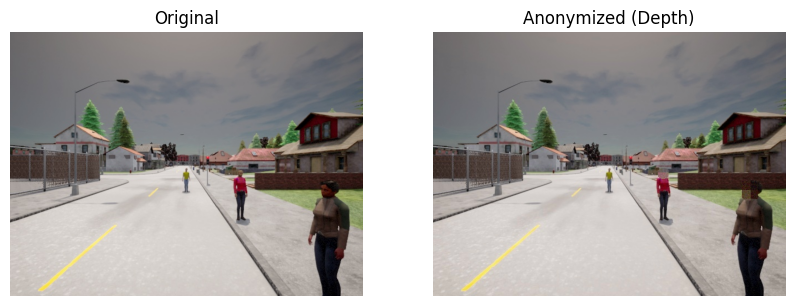

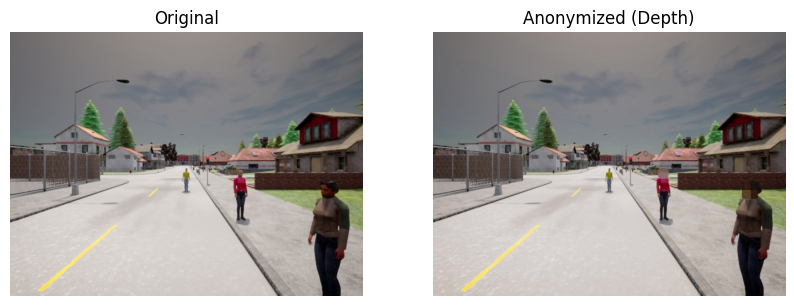

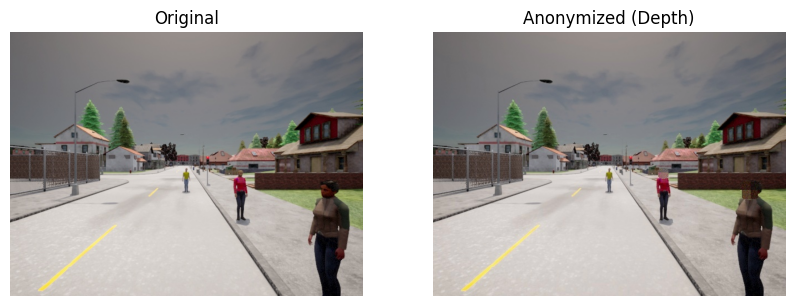

Box-only path samples:


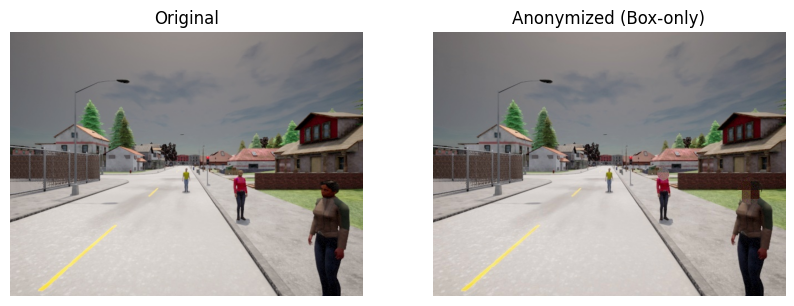

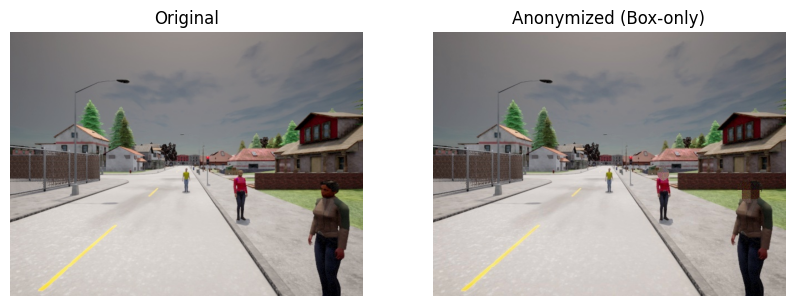

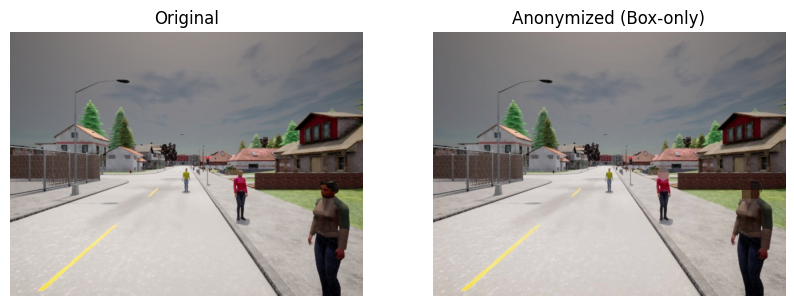

In [12]:

def pick_pairs(df, n=3):
    paths = []
    for _, row in df.head(n).iterrows():
        rgb_name = row["file"]
        out_path = Path(row["path"])
        paths.append( (RGB_DIR / rgb_name, out_path) )
    return paths

pairs_depth = pick_pairs(df_depth, n=3) if 'df_depth' in globals() and not df_depth.empty else []
pairs_box   = pick_pairs(df_box, n=3) if 'df_box' in globals() and not df_box.empty else []

def show_pairs(pairs, title):
    import cv2
    if not pairs:
        print(f"No pairs for {title}")
        return
    for rgb_p, out_p in pairs:
        orig = load_bgr(rgb_p)
        # outputs saved as RGB on disk, load and convert for display helper
        anon_disk = cv2.imread(str(out_p), cv2.IMREAD_COLOR)
        # anon_disk is RGB pixels but cv2 reads as BGR -> convert back to BGR for unified display
        anon_bgr = cv2.cvtColor(anon_disk, cv2.COLOR_BGR2RGB)
        show_side_by_side([orig, anon_bgr], titles=["Original", title], figsize=(10,4))

print("Depth path samples:")
show_pairs(pairs_depth, "Anonymized (Depth)")
print("Box-only path samples:")
show_pairs(pairs_box, "Anonymized (Box-only)")



### Notes & Tips
- **Depth units** don’t need to be meters; the mask uses a z‑score–like rule inside each face box.
- **Block size (`ANON_BLOCK`)** controls granularity: larger blocks => stronger obfuscation and faster.
- **Noise (`ANON_NOISE`)** adds non‑determinism to resist inversion while retaining performance.
- **Oval masks** (with padding) better match facial silhouettes vs rectangles; tune `PAD_RATIO`.
- Enable **depth anonymization** in the class if you need to perturb z‑values too.
